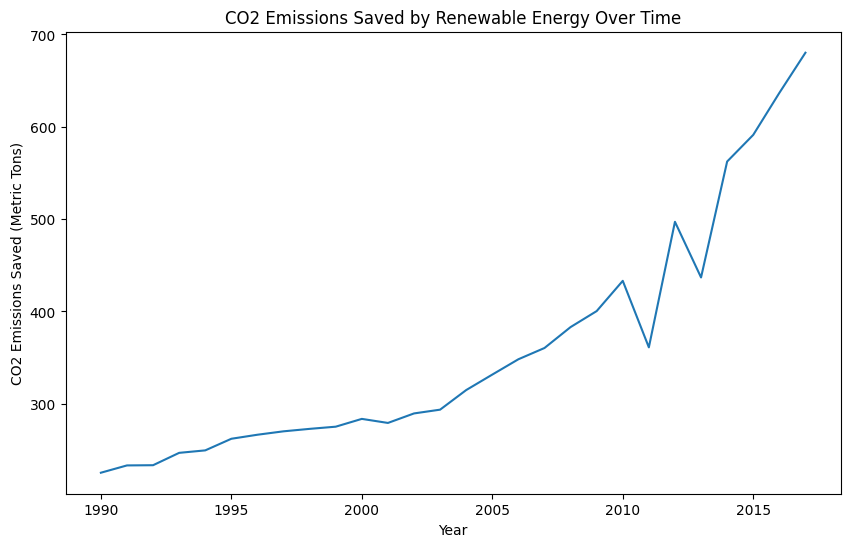

Hydro(TWh) Regression Summary:
                            OLS Regression Results                            
Dep. Variable:             Hydro(TWh)   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     104.0
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.41e-10
Time:                        20:21:00   Log-Likelihood:                -195.61
No. Observations:                  28   AIC:                             395.2
Df Residuals:                      26   BIC:                             397.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.268e+05

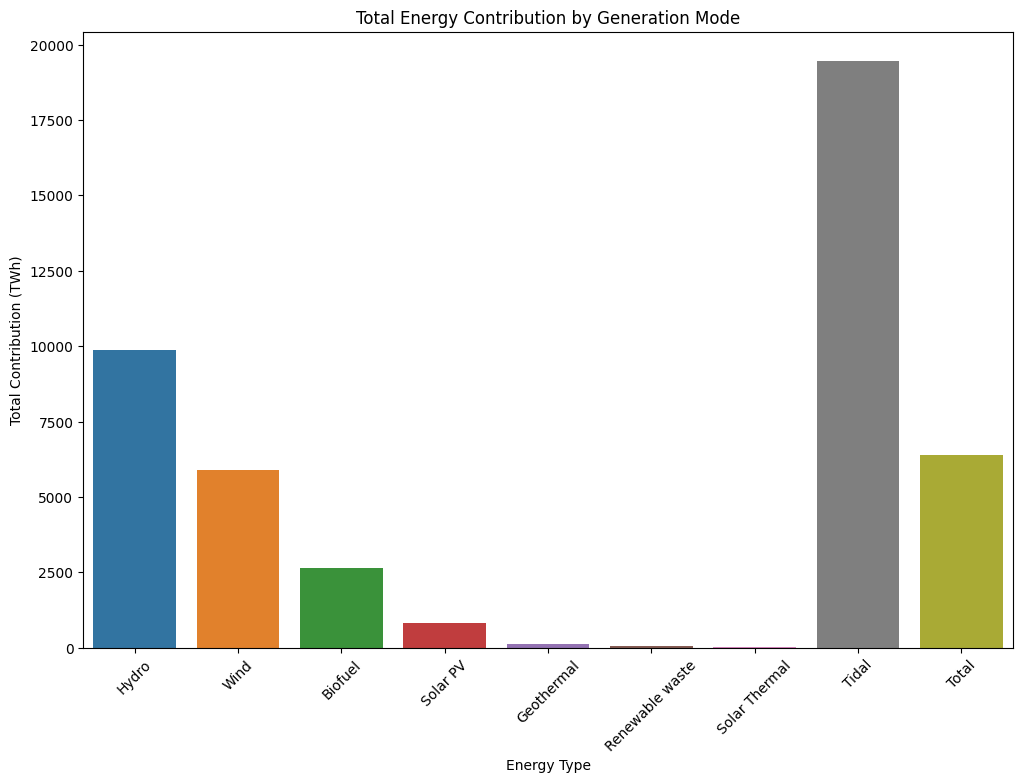

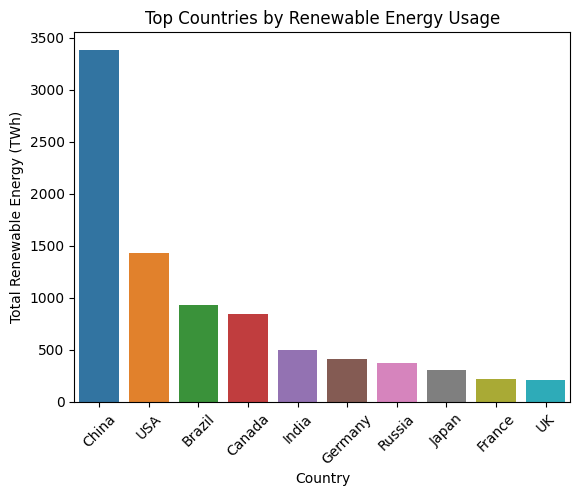

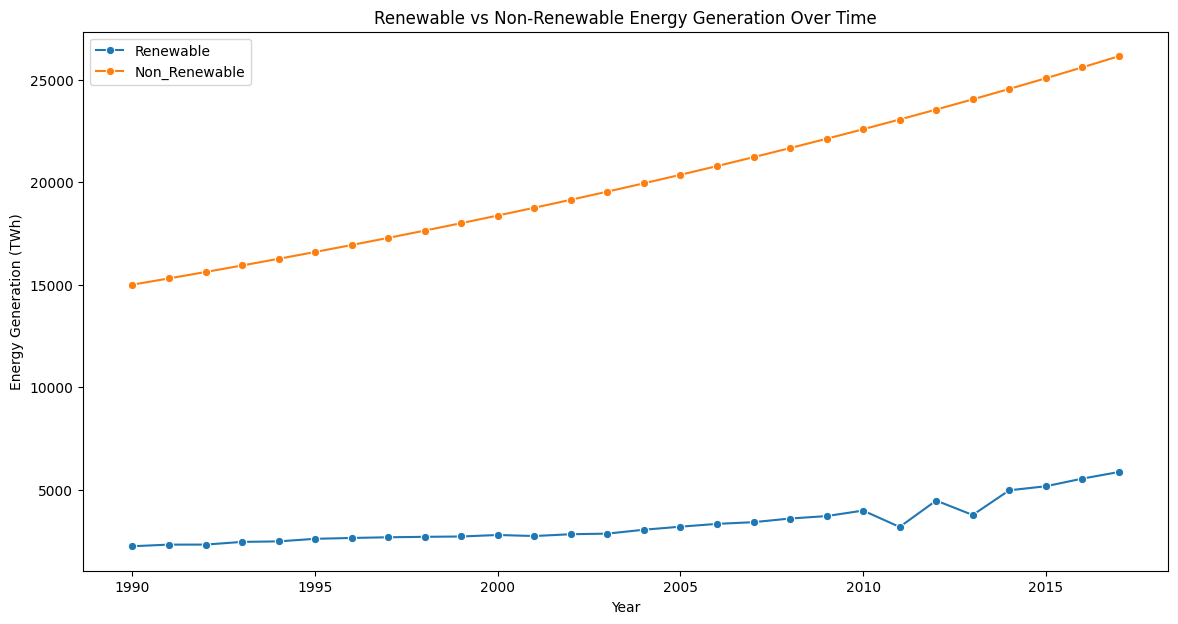

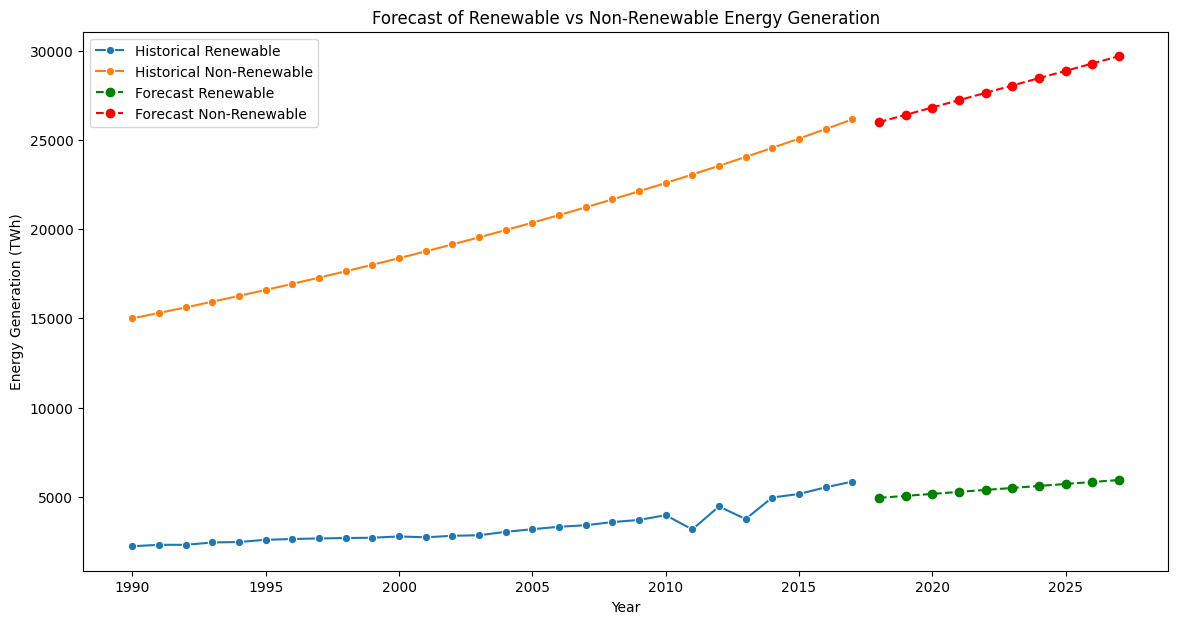

Forecasted Renewable Energy Generation for the next 10 years:
[4943.04174603 5054.03467433 5165.02760263 5276.02053093 5387.01345922
 5498.00638752 5608.99931582 5719.99224412 5830.98517241 5941.97810071]

Forecasted Non-Renewable Energy Generation for the next 10 years:
[25993.2127681  26403.82348303 26814.43419795 27225.04491288
 27635.65562781 28046.26634273 28456.87705766 28867.48777258
 29278.09848751 29688.70920244]


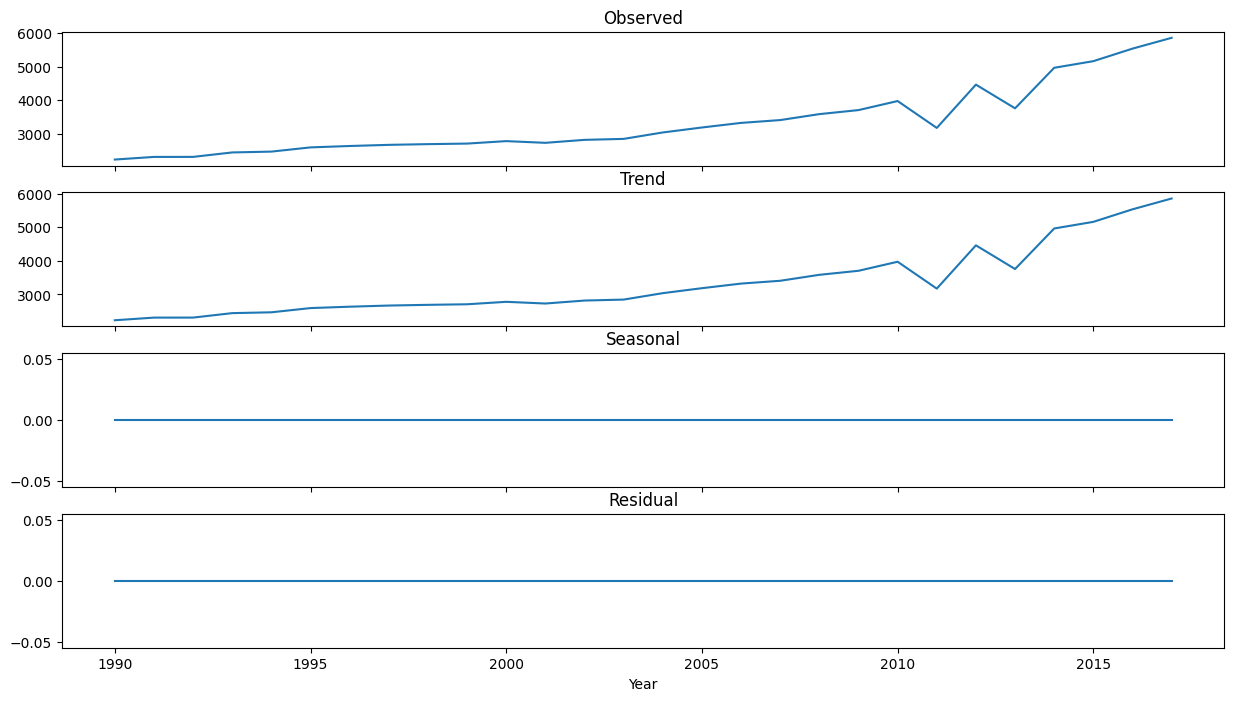

Mean Squared Error of the Random Forest Model: 136078.55546039305


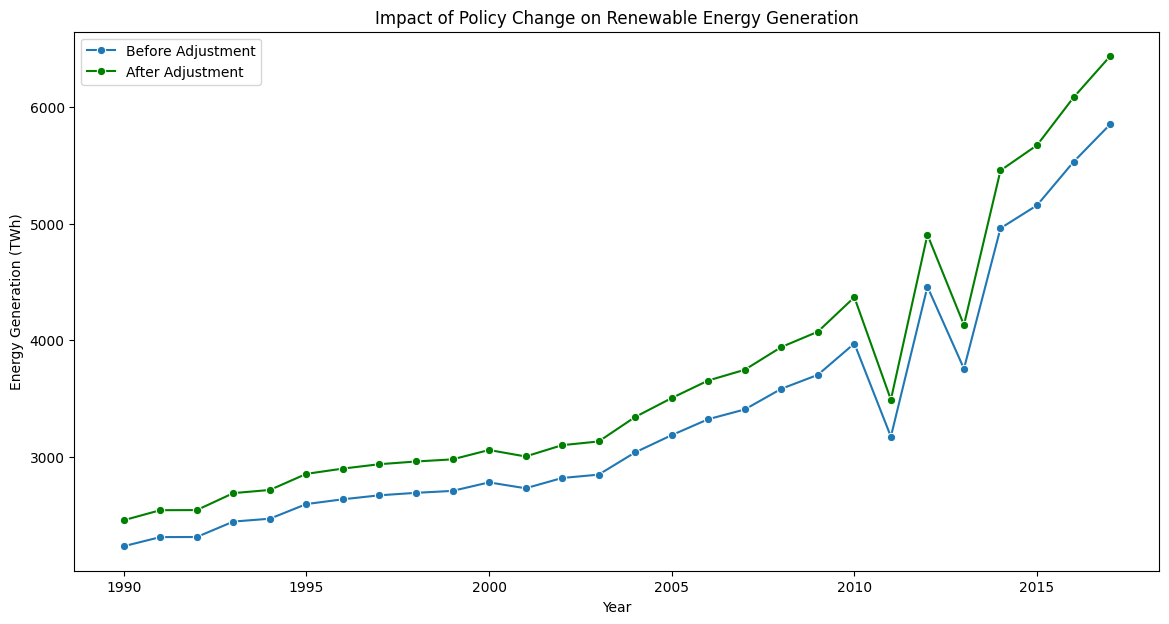

Factor: 0.9, MAE: 834.3476666666679, R^2: -0.716566498612961
Factor: 1, MAE: 200.30566666666732, R^2: 0.8486374975184281
Factor: 1.1, MAE: 2522.3421666666604, R^2: -7.076794903684137


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


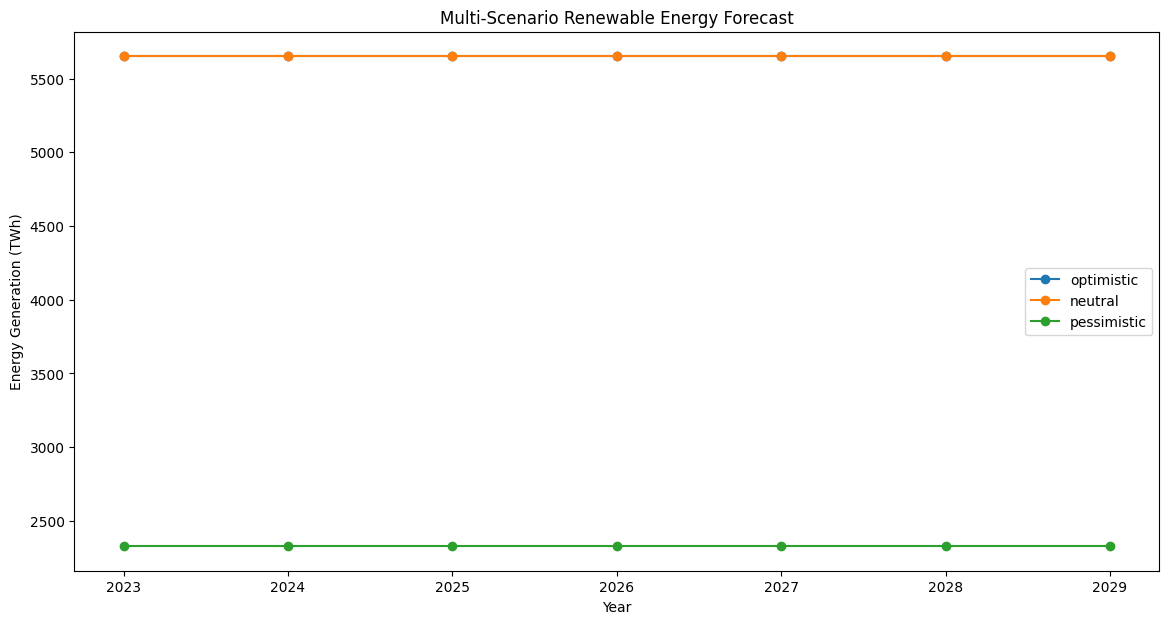

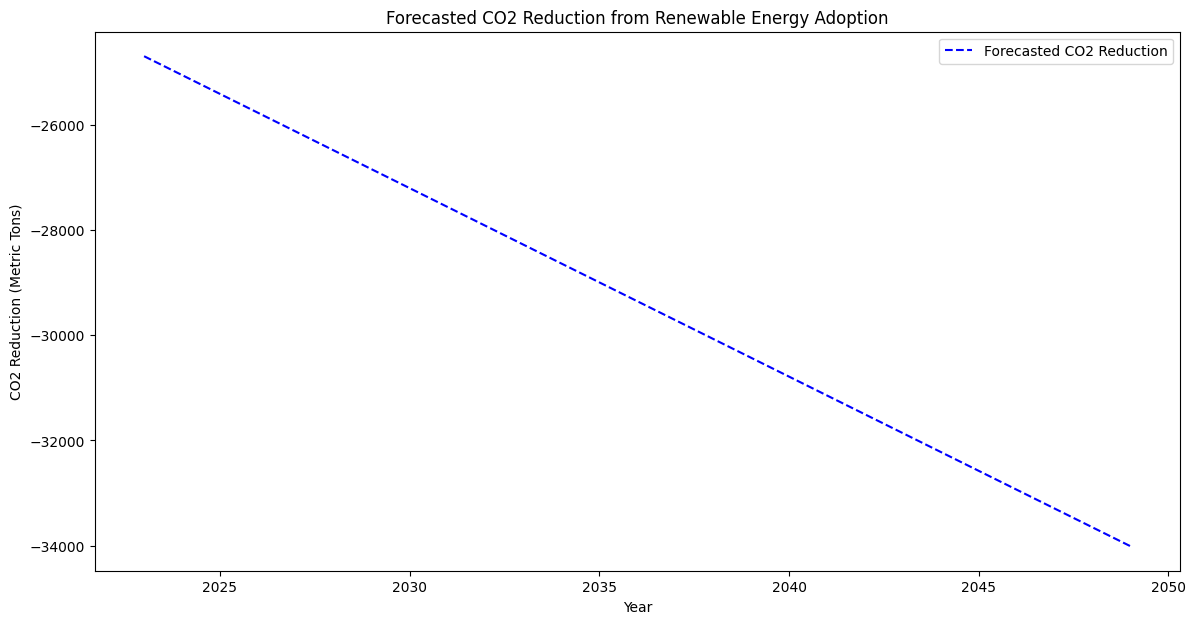

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

# Load data
cont_consump = pd.read_csv("Continent_Consumption_TWH.csv")
country_consump = pd.read_csv("Country_Consumption_TWH.csv")
nonre_eng = pd.read_csv("nonRenewablesTotalPowerGeneration.csv")
re_eng_gen_90_17 = pd.read_csv("renewablePowerGeneration97-17.csv")
re_eng_tot_gen = pd.read_csv("renewablesTotalPowerGeneration.csv")
re_eng_countries = pd.read_csv("top20CountriesPowerGeneration.csv")
nonre_eng_gen_90_17 = pd.read_csv("nonRenewablePowerGeneration90_17.csv")


# Define sensor classes
class Sensor:
    def __init__(self, data, energy_type):
        self.data = data
        self.energy_type = energy_type

    def get_latest_data(self):
        return self.data.iloc[-1]

# Define control system class
class EnergyControlSystem:
    def __init__(self):
        self.sensors = {}

    def add_sensor(self, sensor):
        self.sensors[sensor.energy_type] = sensor

    def decide_energy_distribution(self):
        total_energy = sum(sensor.get_latest_data() for sensor in self.sensors.values())
        return {sensor.energy_type: sensor.get_latest_data() / total_energy for sensor in self.sensors.values()}

# Initialize sensors and control system
hydro_sensor = Sensor(re_eng_gen_90_17['Hydro(TWh)'], "Hydro")
solar_pv_sensor = Sensor(re_eng_gen_90_17['Solar PV (TWh)'], "Solar PV")
biofuel_sensor = Sensor(re_eng_gen_90_17['Biofuel(TWh)'], "Biofuel")
geothermal_sensor = Sensor(re_eng_gen_90_17['Geothermal (TWh)'], "Geothermal")
control_system = EnergyControlSystem()
control_system.add_sensor(hydro_sensor)
control_system.add_sensor(solar_pv_sensor)
control_system.add_sensor(biofuel_sensor)
control_system.add_sensor(geothermal_sensor)

# Decision making for energy distribution
energy_distribution = control_system.decide_energy_distribution()


# Function to calculate emissions savings
def calculate_emissions_savings(dataframe, emissions_factors):
    dataframe['CO2_emissions_saved'] = dataframe.apply(
        lambda x: sum(x[type] * emissions_factors[type] for type in emissions_factors), axis=1
    )
    return dataframe

emissions_factors = {'Hydro(TWh)': 0.1, 'Solar PV (TWh)': 0.05, 'Biofuel(TWh)': 0.2, 'Geothermal (TWh)': 0.15}
re_eng_gen_90_17 = calculate_emissions_savings(re_eng_gen_90_17, emissions_factors)


# This script needs to be further expanded with actual analysis steps, data cleaning processes, and visualization codes.

# Perform data visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=re_eng_gen_90_17, x='Year', y='CO2_emissions_saved')
plt.title('CO2 Emissions Saved by Renewable Energy Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions Saved (Metric Tons)')
plt.show()

# Perform regression analysis on renewable energy generation over time
for energy_type in ['Hydro(TWh)', 'Biofuel(TWh)', 'Solar PV (TWh)', 'Geothermal (TWh)']:
    X = sm.add_constant(re_eng_gen_90_17['Year'])
    y = re_eng_gen_90_17[energy_type]
    model = sm.OLS(y, X).fit()
    print(f"{energy_type} Regression Summary:")
    print(model.summary())
    print("\n")

# Correlation between renewable energy generation and CO2 emissions saved
for energy_type in emissions_factors.keys():
    correlation = pearsonr(re_eng_gen_90_17[energy_type], re_eng_gen_90_17['CO2_emissions_saved'])
    print(f"Correlation between {energy_type} and CO2 emissions saved: {correlation[0]}")

# Visualize the distribution of energy generation types
energy_types = re_eng_tot_gen['Mode of Generation'].unique()
energy_contributions = [re_eng_tot_gen[re_eng_tot_gen['Mode of Generation'] == energy_type]['Contribution (TWh)'].sum() for energy_type in energy_types]

plt.figure(figsize=(12, 8))
sns.barplot(x=energy_types, y=energy_contributions)
plt.title('Total Energy Contribution by Generation Mode')
plt.xlabel('Energy Type')
plt.ylabel('Total Contribution (TWh)')
plt.xticks(rotation=45)
plt.show()

# Analyze and visualize top countries using renewable energy
top_countries_by_renewable = re_eng_countries.set_index('Country').sum(axis=1).nlargest(10)
sns.barplot(x=top_countries_by_renewable.index, y=top_countries_by_renewable.values)
plt.title('Top Countries by Renewable Energy Usage')
plt.xlabel('Country')
plt.ylabel('Total Renewable Energy (TWh)')
plt.xticks(rotation=45)
plt.show()


# Ensure to fill in the placeholder '...' with actual code for specific analysis and decision-making process.

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare the data for trend analysis
re_eng_gen_90_17['total_renew_energy_Twh'] = (re_eng_gen_90_17['Hydro(TWh)'] +
                                              re_eng_gen_90_17['Biofuel(TWh)'] +
                                              re_eng_gen_90_17['Solar PV (TWh)'] +
                                              re_eng_gen_90_17['Geothermal (TWh)'])
nonre_eng_gen_90_17['total_nonrenew_energy_Twh'] = (nonre_eng_gen_90_17['Coal'] +
                                              nonre_eng_gen_90_17['Natural Gas'] +
                                              nonre_eng_gen_90_17['Nuclear'] +
                                              nonre_eng_gen_90_17['Oil'])


renewable_totals = re_eng_gen_90_17[['Year', 'total_renew_energy_Twh']]
#renewable_totals = re_eng_tot_gen[['Mode of Generation', 'Contribution (TWh)']]
#nonrenewable_totals = nonre_eng[['Year', 'Total']]  # Assuming 'Total' column exists with total non-renewable TWh
nonrenewable_totals = nonre_eng_gen_90_17[['Year', 'total_nonrenew_energy_Twh']]

# Merge datasets on 'Year'
energy_totals = pd.merge(renewable_totals, nonrenewable_totals, on='Year', how='inner')
energy_totals.rename(columns={'total_renew_energy_Twh': 'Renewable', 'total_nonrenew_energy_Twh': 'Non_Renewable'}, inplace=True)

# Trend Analysis with Visualization
plt.figure(figsize=(14, 7))
#sns.lineplot(x='Year', y='Renewable', data=energy_totals, marker='o', label='Renewable')
sns.lineplot(x='Year', y='Renewable', data=energy_totals, marker='o', label='Renewable')
sns.lineplot(x='Year', y='Non_Renewable', data=energy_totals, marker='o', label='Non_Renewable')
plt.title('Renewable vs Non-Renewable Energy Generation Over Time')
plt.xlabel('Year')
plt.ylabel('Energy Generation (TWh)')
plt.legend()
plt.show()

# Forecasting future adoption rates of renewable energy
# Fit a linear regression model
X = energy_totals['Year'].values.reshape(-1, 1)
y_renew = energy_totals['Renewable'].values
y_nonrenew = energy_totals['Non_Renewable'].values

model_renew = LinearRegression().fit(X, y_renew)
model_nonrenew = LinearRegression().fit(X, y_nonrenew)

# Predict the next 10 years
future_years = np.arange(energy_totals['Year'].max() + 1, energy_totals['Year'].max() + 11).reshape(-1, 1)
future_renew_pred = model_renew.predict(future_years)
future_nonrenew_pred = model_nonrenew.predict(future_years)

# Visualization of forecast
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Renewable', data=energy_totals, marker='o', label='Historical Renewable')
sns.lineplot(x='Year', y='Non_Renewable', data=energy_totals, marker='o', label='Historical Non-Renewable')
plt.plot(future_years.flatten(), future_renew_pred, 'go--', label='Forecast Renewable')
plt.plot(future_years.flatten(), future_nonrenew_pred, 'ro--', label='Forecast Non-Renewable')
plt.title('Forecast of Renewable vs Non-Renewable Energy Generation')
plt.xlabel('Year')
plt.ylabel('Energy Generation (TWh)')
plt.legend()
plt.show()

# Print out the forecasted values
print("Forecasted Renewable Energy Generation for the next 10 years:")
print(future_renew_pred)
print("\nForecasted Non-Renewable Energy Generation for the next 10 years:")
print(future_nonrenew_pred)

# Additional advanced analyses could include:
# - Time series decomposition to identify underlying patterns
# - Machine learning models for more accurate predictions
# - Scenario analysis to evaluate the impact of policy changes or technological advancements

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Time series decomposition to identify underlying patterns in renewable energy generation
renewable_ts = energy_totals.set_index('Year')['Renewable']
decomposition = seasonal_decompose(renewable_ts, model='additive', period=1)  # Assuming annual data, hence period=1

# Plot the decomposition results
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], legend=False, title='Observed')
decomposition.trend.plot(ax=axes[1], legend=False, title='Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, title='Residual')
plt.show()

# Machine learning models for more accurate predictions
# Prepare the features (X) and the target (y)
X = energy_totals[['Year']]
y = energy_totals['Renewable']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of the Random Forest Model: {mse}")

# Scenario analysis to evaluate the impact of policy changes or technological advancements
# Define a function to adjust energy generation based on a hypothetical policy or technological change
def adjust_energy_generation(year, adjustment_factor):
    adjusted_generation = energy_totals.copy()
    adjusted_generation['Renewable'] = adjusted_generation['Renewable'].apply(
        lambda x: x * adjustment_factor if year >= 2020 else x
    )
    return adjusted_generation

# Hypothetical scenario: a policy change leads to a 10% increase in renewable energy generation from 2020 onwards
adjusted_energy_totals = adjust_energy_generation(2020, 1.1)

# Visualize the impact of the policy change
plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Renewable', data=energy_totals, marker='o', label='Before Adjustment')
sns.lineplot(x='Year', y='Renewable', data=adjusted_energy_totals, marker='o', label='After Adjustment', color='green')
plt.title('Impact of Policy Change on Renewable Energy Generation')
plt.xlabel('Year')
plt.ylabel('Energy Generation (TWh)')
plt.legend()
plt.show()

# The scenario analysis above is simplified and can be expanded based on more complex policy changes or technological advancements.
# Further steps might include sensitivity analysis or multi-scenario forecasting to consider various possible futures.

from sklearn.metrics import mean_absolute_error, r2_score
import itertools

# Define a sensitivity analysis function to test various scenarios
def sensitivity_analysis(model, X_test, y_test, factors):
    results = []
    for factor in factors:
        # Adjust the test set based on the factor
        X_test_adjusted = X_test.copy()
        X_test_adjusted['Year'] *= factor

        # Make predictions with the adjusted test set
        predictions = model.predict(X_test_adjusted)

        # Calculate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        results.append((factor, mae, r2))

    return results

# Perform sensitivity analysis
factors = [0.9, 1, 1.1]  # For example, a 10% decrease, no change, and a 10% increase
sensitivity_results = sensitivity_analysis(rf_model, X_test, y_test, factors)

# Print sensitivity analysis results
for factor, mae, r2 in sensitivity_results:
    print(f"Factor: {factor}, MAE: {mae}, R^2: {r2}")

# Multi-scenario forecasting
# Define different scenarios for future energy policy or market conditions
scenarios = {
    'optimistic': 1.2,
    'neutral': 1.0,
    'pessimistic': 0.8
}

future_years = np.arange(2023, 2030).reshape(-1, 1)  # Predict the next 7 years
scenario_predictions = {}

# Predict future energy generation for each scenario
for scenario, factor in scenarios.items():
    # Adjust the future_years based on the scenario factor
    adjusted_future_years = future_years * factor
    predictions = rf_model.predict(adjusted_future_years)
    scenario_predictions[scenario] = predictions

# Visualize multi-scenario forecasting
plt.figure(figsize=(14, 7))
for scenario, predictions in scenario_predictions.items():
    plt.plot(range(2023, 2030), predictions, marker='o', label=scenario)

plt.title('Multi-Scenario Renewable Energy Forecast')
plt.xlabel('Year')
plt.ylabel('Energy Generation (TWh)')
plt.legend()
plt.show()

# Note that this is a simplified forecasting model. For more accurate future projections,
# consider incorporating additional variables and using more complex models.

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Hybrid Embedded System Simulation
# Define a class that simulates a hybrid embedded system for energy management
class HybridEnergySystem:
    def __init__(self, renewable_model, non_renewable_model):
        self.renewable_model = renewable_model
        self.non_renewable_model = non_renewable_model

    def predict_energy_output(self, year):
        renewable_energy = self.renewable_model.predict(np.array([[year]]))
        non_renewable_energy = self.non_renewable_model.predict(np.array([[year]]))
        return renewable_energy, non_renewable_energy

    def simulate_CO2_reduction(self, renewable_energy, non_renewable_energy, co2_emission_factors):
        renewable_co2_reduction = renewable_energy * co2_emission_factors['Renewable']
        non_renewable_co2_emissions = non_renewable_energy * co2_emission_factors['Non_Renewable']
        net_co2_reduction = renewable_co2_reduction - non_renewable_co2_emissions
        return net_co2_reduction

# Initialize the hybrid system with trained models
hybrid_system = HybridEnergySystem(model_renew, model_nonrenew)

# Define CO2 emission factors for renewable and non-renewable energy (in metric tons per TWh)
co2_emission_factors = {
    'Renewable': 0.1,   # Emission factor for renewable energy
    'Non_Renewable': 0.9 # Emission factor for non-renewable energy
}

# Predict future CO2 reductions
years = np.arange(2023, 2050)
predicted_co2_reductions = []
for year in years:
    renewable_energy, non_renewable_energy = hybrid_system.predict_energy_output(year)
    co2_reduction = hybrid_system.simulate_CO2_reduction(renewable_energy, non_renewable_energy, co2_emission_factors)
    predicted_co2_reductions.append(co2_reduction)

# Visualize the forecasted CO2 reductions
plt.figure(figsize=(14, 7))
plt.plot(years, predicted_co2_reductions, 'b--', label='Forecasted CO2 Reduction')
plt.title('Forecasted CO2 Reduction from Renewable Energy Adoption')
plt.xlabel('Year')
plt.ylabel('CO2 Reduction (Metric Tons)')
plt.legend()
plt.show()

